# Description

### The following code uses the MNIST dataset of handwritten digits' images, and attempts to correctly classify them as numbers from 0 to 9.
### It uses a Convolutional neural network, which uses parallel pooling (Max and Range) to achieve state-of-the-art results.

# Import libraries

In [12]:
import numpy as np
np.random.seed(1)
from collections import Counter
import tensorflow as tf
tf.random.set_seed(1)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, ReLU
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (12,5)
from warnings import filterwarnings
filterwarnings('ignore')

# Load and Pre-process data

In [13]:
# load mnist dataset (handwritten digits' images)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# reshape data to fit model
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# scale data by dividing by max of training data
max_val = x_train.max()
x_train_scaled = x_train / max_val
x_test_scaled = x_test / max_val

# one-hot encode target column
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

# Distribution of labels

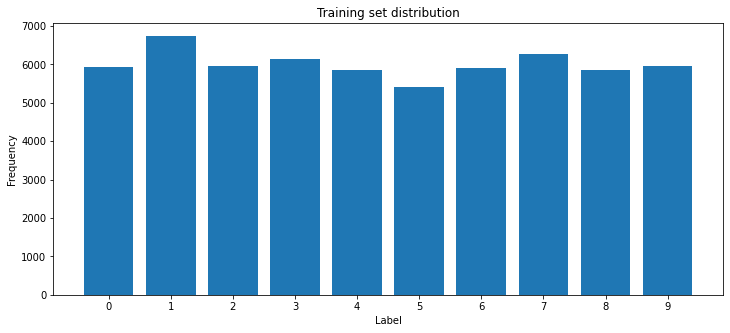

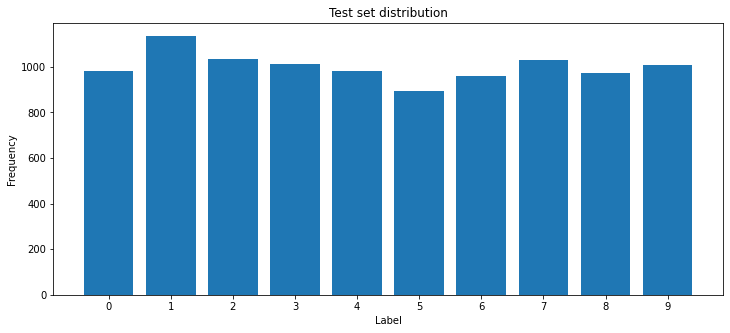

In [14]:
# Training data
counter_train = Counter(y_train)
plt.bar(counter_train.keys(), counter_train.values())
plt.title('Training set distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(list(counter_train.keys()))
plt.show()

# Test data
counter_test = Counter(y_test)
plt.bar(counter_test.keys(), counter_test.values())
plt.title('Test set distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(list(counter_test.keys()))
plt.show()

# Create CNN model

In [15]:
# input layer
x = Input(shape=x_train_scaled.shape[1:])

# convolution layer
conv = Conv2D(filters=10, kernel_size=3, activation='linear', padding='valid')(x)

# parallel pooling
max_pool = MaxPooling2D(pool_size=5, strides=2, padding='valid')(conv)
range_pool = MaxPooling2D(pool_size=5, strides=2, padding='valid')(tf.math.negative(conv))
range_pool = tf.math.subtract(max_pool, tf.math.negative(range_pool))
parallel_pool = Concatenate()([max_pool, range_pool])

# flattening and relu activation
features = Flatten()(parallel_pool)
features = ReLU()(features)

# dense and output layer
dense = Dense(units=500, activation='relu')(features)
output = Dense(units=10, activation='softmax', name='output')(dense)

# create model and plot its structure
model = Model(inputs=x, outputs=output)
print(model.summary())

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 26, 26, 10)   100         input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Neg_4 (TensorFlowOp [(None, 26, 26, 10)] 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 11, 11, 10)   0           tf_op_layer_Neg_4[0][0]          
_______________________________________________________________________________________

# Fit Model

In [16]:
# Define callbacks for checkpoint and early stopping
ckpt = tf.keras.callbacks.ModelCheckpoint(filepath='cnn_model', mode='min', monitor='val_loss', save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', restore_best_weights=True)

# Compile and train model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fitted_model = model.fit(x_train_scaled, y_train_encoded,
                         validation_data=(x_test_scaled, y_test_encoded),
                         epochs=30, batch_size=128,
                         callbacks=[ckpt, early_stop])
history = fitted_model.history

Epoch 1/30
469/469 [==============================] - 31s 66ms/step - loss: 0.2041 - accuracy: 0.9388 - val_loss: 0.0851 - val_accuracy: 0.9724
Epoch 2/30
469/469 [==============================] - 30s 63ms/step - loss: 0.0745 - accuracy: 0.9763 - val_loss: 0.0749 - val_accuracy: 0.9749
Epoch 3/30
469/469 [==============================] - 30s 64ms/step - loss: 0.0532 - accuracy: 0.9834 - val_loss: 0.0523 - val_accuracy: 0.9819
Epoch 4/30
469/469 [==============================] - 32s 69ms/step - loss: 0.0461 - accuracy: 0.9858 - val_loss: 0.0402 - val_accuracy: 0.9866
Epoch 5/30
469/469 [==============================] - 29s 61ms/step - loss: 0.0393 - accuracy: 0.9873 - val_loss: 0.0513 - val_accuracy: 0.9822
Epoch 6/30
469/469 [==============================] - 29s 62ms/step - loss: 0.0320 - accuracy: 0.9895 - val_loss: 0.0481 - val_accuracy: 0.9845
Epoch 7/30
469/469 [==============================] - 30s 64ms/step - loss: 0.0328 - accuracy: 0.9892 - val_loss: 0.0552 - val_accuracy:

# Plot Model results

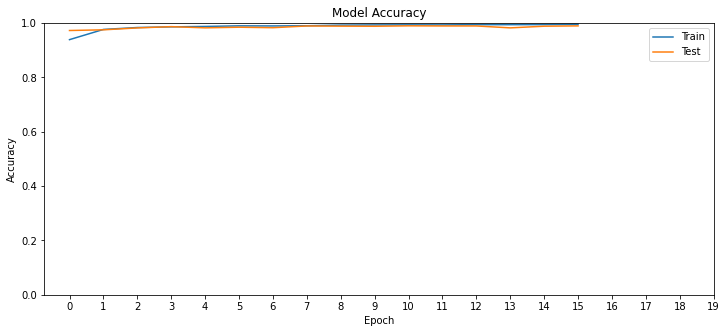

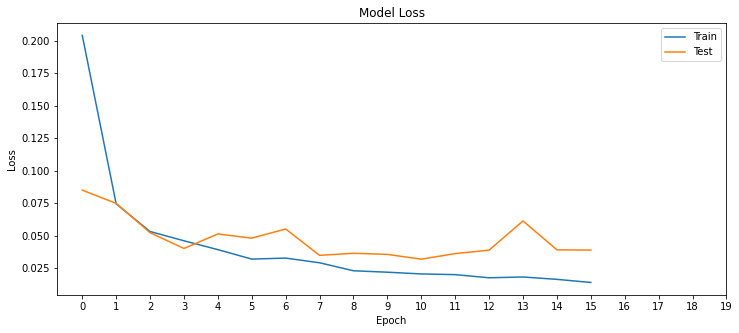

In [17]:
# Accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.ylim([0, 1])
plt.xticks(range(0,20))
plt.show()

# Loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.xticks(range(0,20))
plt.show()